## Parameters

In [1]:
LAMBDA = 0.5
CENTER_LOSS_ALPHA = 0.5
NUM_CLASSES = 7

## Import modules

In [2]:
import tensorflow.compat.v1 as tf
import tf_slim as slim
import tflearn
import os, os.path
import pandas as pd
import time
import numpy as np
from numpy import ndarray
import skimage
from skimage import data, io, filters, transform, exposure
import random
from sklearn.utils import shuffle

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
tf.reset_default_graph()
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


## Construct network

In [3]:
with tf.name_scope('input'):
    input_images = tf.placeholder(tf.float32, shape=(None,48,48,1), name='input_images')
    labels = tf.placeholder(tf.int64, shape=(None), name='labels')
    
global_step = tf.Variable(0, trainable=False, name='global_step')

In [4]:
def get_center_loss(features, labels, alpha, num_classes):
    # Obtain feature number
    len_features = features.get_shape()[1]
    # Set a valiable to store all the samples
    centers = tf.get_variable('centers', [num_classes, len_features], dtype=tf.float32,
        initializer=tf.constant_initializer(0), trainable=False)
    # fallen the label
    labels = tf.reshape(labels, [-1])
    
    # calculate the center of mini-batch
    centers_batch = tf.gather(centers, labels)
    # calculate the loss
    loss = tf.nn.l2_loss(features - centers_batch)
    
    # the difference between the features and the center
    diff = centers_batch - features
    
    # count the frequency of samples in each category
    unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
    appear_times = tf.gather(unique_count, unique_idx)
    appear_times = tf.reshape(appear_times, [-1, 1])
    
    diff = diff / tf.cast((1 + appear_times), tf.float32)
    diff = alpha * diff
    
    centers_update_op = tf.scatter_sub(centers, labels, diff)
    
    return loss, centers, centers_update_op

In [5]:
def inference(input_images):
    with slim.arg_scope([slim.conv2d], kernel_size=5, padding='SAME'):
        with slim.arg_scope([slim.max_pool2d], kernel_size=2):
            
            x = slim.conv2d(input_images, num_outputs=32, scope='conv1_1')
            x = slim.conv2d(x, num_outputs=32, scope='conv1_2')
            x = slim.max_pool2d(x, scope='pool1')
     
            x = slim.conv2d(x, num_outputs=64, scope='conv2_1')
            x = slim.conv2d(x, num_outputs=64, scope='conv2_2')
            x = slim.max_pool2d(x, scope='pool2')
            
            x = slim.flatten(x, scope='flatten')
            
            feature = slim.fully_connected(x, num_outputs=2, activation_fn=None, scope='fc1')
            
            x = tflearn.prelu(feature)

            x = slim.fully_connected(x, num_outputs=7, activation_fn=None, scope='fc2')
    
    return x, feature

In [6]:
# If you want to modify the usage of center_loss
# Please comment or uncomment the "total_loss" line's part "+ ratio * center_loss"

def build_network(input_images, labels, ratio=0.5):
    logits, features = inference(input_images)
    
    with tf.name_scope('loss'):
        with tf.name_scope('center_loss'):
            center_loss, centers, centers_update_op = get_center_loss(features, labels, CENTER_LOSS_ALPHA, NUM_CLASSES)
        with tf.name_scope('softmax_loss'):
            softmax_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        with tf.name_scope('total_loss'):
            total_loss = softmax_loss# + ratio * center_loss
    
    with tf.name_scope('acc'):
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(logits, 1), labels), tf.float32))
    
    with tf.name_scope('loss/'):
        tf.summary.scalar('CenterLoss', center_loss)
        tf.summary.scalar('SoftmaxLoss', softmax_loss)
        tf.summary.scalar('TotalLoss', total_loss)
        
    return logits, features, total_loss, accuracy, centers_update_op

In [7]:
logits, features, total_loss, accuracy, centers_update_op = build_network(input_images, labels, ratio=LAMBDA)

c:\users\38953\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
c:\users\38953\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


## Prepare data

In [8]:
####################################### DATA PREPROCESSING - Labeling ################################################
'''
This function traverses throwe ach directory of training images
Two lists are made:
    - The RGB image values are added to the images list
    - For every photo in say the 'angry' directory of images, a 
      corresponding label is added to the label list

'''
class DataLoader():
    def __init__(self, TRAINING_DIR, TESTING_DIR):
        self._index_in_epoch = 0 
        self._epochs_completed = 0 
    
        self.train_data = []
        self.train_label = []
        self.num_train_data = 0
        self.test_data = []
        self.test_label = []
        self.num_test_data = 0
        directories = [d for d in os.listdir(TRAINING_DIR) 
                    if os.path.isdir(os.path.join(TRAINING_DIR, d))]
        # training data set and labels
        for d in directories:
            label_directory = os.path.join(TRAINING_DIR, d)
            file_names = [os.path.join(label_directory, f) 
                            for f in os.listdir(label_directory) 
                              if f.endswith(".png")]
            
            for f in file_names:
                self.train_data.append(io.imread(f))
                self.train_label.append(int(d))
        self.train_data = np.array(self.train_data)
        self.train_label = np.array(self.train_label)
        self.train_data, self.train_label = shuffle(self.train_data, self.train_label)
        self.train_data = np.expand_dims(self.train_data.astype(np.float32)/255.0,axis=-1)
        self.train_label = self.train_label.astype(np.float32)
        self.num_train_data = len(self.train_data)
        
        # test data set and labels        
        directories = [d for d in os.listdir(TESTING_DIR) 
                    if os.path.isdir(os.path.join(TESTING_DIR, d))]

        for d in directories:
            label_directory = os.path.join(TESTING_DIR, d)
            file_names = [os.path.join(label_directory, f) 
                            for f in os.listdir(label_directory) 
                              if f.endswith(".png")]
            
            for f in file_names:
                self.test_data.append(io.imread(f))
                self.test_label.append(int(d))
        self.test_data = np.array(self.test_data)
        self.test_label = np.array(self.test_label)
        self.test_data, self.test_label = shuffle(self.test_data, self.test_label)
        self.test_data = np.expand_dims(self.test_data.astype(np.float32)/255.0,axis=-1)
        self.test_label = self.test_label.astype(np.float32)
        self.num_test_data = len(self.test_data)

    def get_batch(self, batch_size):
        index = np.random.randint(0, np.shape(self.train_data)[0],batch_size)
        return self.train_data[index][:], self.train_label[index]
    
    def next_batch(self, batch_size): 
        start = self._index_in_epoch 
        if ((start == 0) and (self._epochs_completed == 0)): 
            self.train_data, self.train_label = shuffle(self.train_data, self.train_label)

        # go to the next batch 
        if (start + batch_size > self.num_train_data): 
            self._epochs_completed += 1 
            rest_num_examples = self.num_train_data - start 
            data_rest_part = self.train_data[start:self.num_train_data] 
            label_rest_part = self.train_label[start:self.num_train_data]
            self.train_data, self.train_label = shuffle(self.train_data, self.train_label)

            start = 0 
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size 
            end = self._index_in_epoch 
            data_new_part = self.train_data[start:end] 
            label_new_part = self.train_label[start:end]
            return np.concatenate((data_rest_part, data_new_part), axis=0), np.concatenate((label_rest_part, label_new_part), axis=0)
        else: 
            self._index_in_epoch += batch_size 
            end = self._index_in_epoch 
            return self.train_data[start:end], self.train_label[start:end]

TRAINING_DIR = './data/train'
TESTING_DIR = './data/test'
data_loader = DataLoader(TRAINING_DIR, TESTING_DIR)

## Optimizer

In [9]:
optimizer = tf.train.AdamOptimizer(0.001)

In [10]:
with tf.control_dependencies([centers_update_op]):
    train_op = optimizer.minimize(total_loss, global_step=global_step)

## Session and Summary

In [11]:
summary_op = tf.summary.merge_all()

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('./mnist_log', sess.graph)

## Train and Test

In [13]:
mean_data = np.mean(data_loader.train_data, axis=0)

In [14]:
step = sess.run(global_step)
while step <= 1000:
    batch_images, batch_labels = data_loader.next_batch(128)
    _, summary_str, train_acc = sess.run(
        [train_op, summary_op, accuracy],
        feed_dict={
            input_images: batch_images - mean_data,
            labels: batch_labels,
        })
    step += 1
    
    writer.add_summary(summary_str, global_step=step)
    
    if step % 100 == 0:
        test_acc = sess.run(
            accuracy,
            feed_dict={
                input_images: data_loader.test_data - mean_data,
                labels: data_loader.test_label,
            })
        print(("step: {}, train_acc:{:.4f}, test_acc:{:.4f}".
              format(step, train_acc, test_acc)))

step: 100, train_acc:0.6719, test_acc:0.4286
step: 200, train_acc:0.7891, test_acc:0.5714
step: 300, train_acc:0.9688, test_acc:0.8000
step: 400, train_acc:0.9844, test_acc:0.8714
step: 500, train_acc:0.9922, test_acc:0.9714
step: 600, train_acc:1.0000, test_acc:0.9429
step: 700, train_acc:1.0000, test_acc:0.9714
step: 800, train_acc:1.0000, test_acc:0.9714
step: 900, train_acc:1.0000, test_acc:0.9714
step: 1000, train_acc:1.0000, test_acc:0.9857


### Visualize train_data

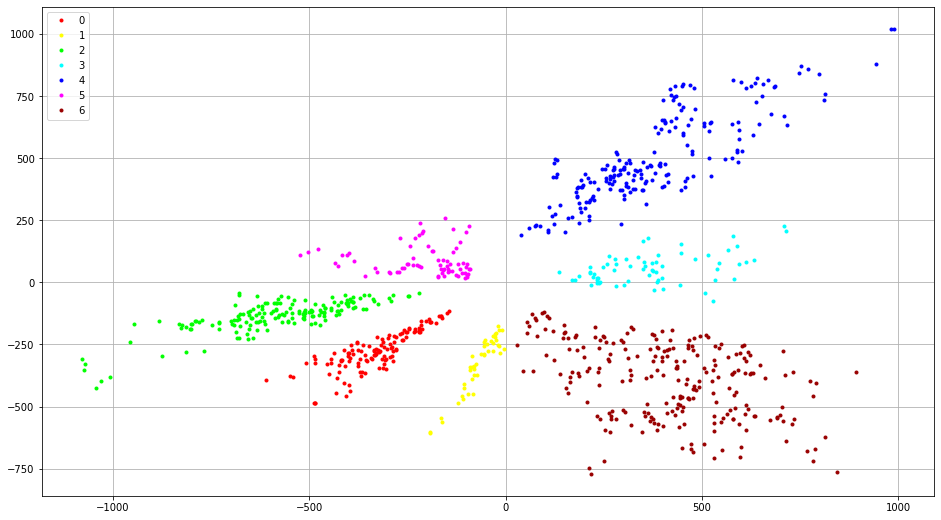

In [15]:
feat = sess.run(features, feed_dict={input_images:data_loader.train_data[:data_loader.num_train_data]-mean_data})

%matplotlib inline
import matplotlib.pyplot as plt

labels = data_loader.train_label[:data_loader.num_train_data]

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000']
for i in range(7):
    plt.plot(feat[labels==i,0].flatten(), feat[labels==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6'])
plt.grid()
plt.show()

### Visualize test_data

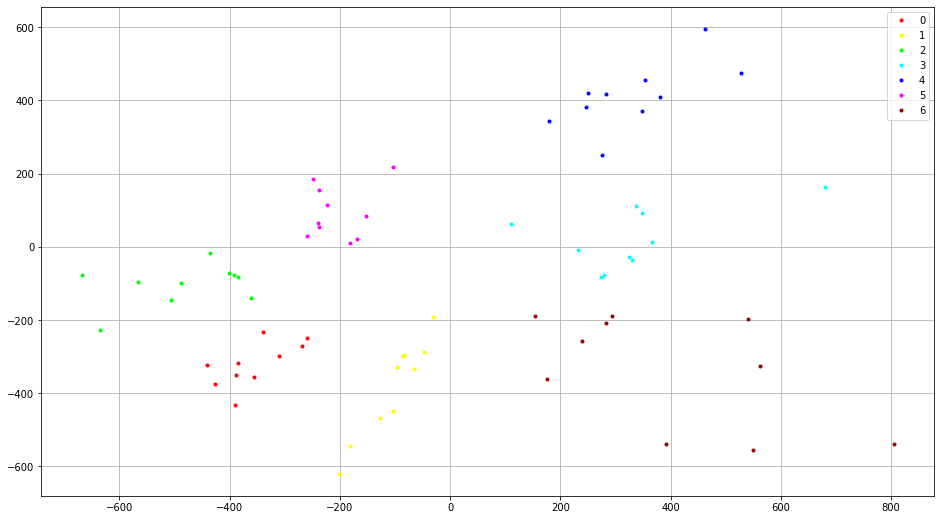

In [16]:
feat = sess.run(features, feed_dict={input_images:data_loader.test_data[:data_loader.num_test_data]-mean_data})

%matplotlib inline
import matplotlib.pyplot as plt

labels = data_loader.test_label[:data_loader.num_test_data]

f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
     '#ff00ff', '#990000']
for i in range(7):
    plt.plot(feat[labels==i,0].flatten(), feat[labels==i,1].flatten(), '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6'])
plt.grid()
plt.show()

In [17]:
sess.close()